# MICROBIOLOGICAL RESEARCH - UPDATED VERSION

NOTE : For entire project with input and output files please visit this link : https://drive.google.com/drive/folders/11kIDx0BxYtWfuHhj816JtsDhL2yTKdSW?usp=sharing

NOTE : To run the project, download the zip file 'Dragonfruit_v2.zip' from the folder link above. Open the unzipped folder in VSCode or any other text editor and run the 'Shikhar_Singh_DFAI_updated_v2.ipynb' file 

## PROBLEM UNDERSTANDING:

Premise 1:
- I'm working with microbiological researchers who are investigating cancer in parasitic micro-organisms
- Researchers have an electron microscope that can capture very high resolution images of micro-organisms (MOs for simplicity). (100000 x 100000 pixels)
- Each image is an image of a single MO. It is blob of arbitrary shape. MO blob covers >25% of the whole image
- Image can be viewed as : if pixel black -> it is within or MO boundary, else -> it is the area outside the MO
- There are no white spaces inside the MO blob

Premise 2:
- Researchers have injected the MO with a dye that lights up wherever the dye is present 
- This sensor also captures an image of the same MO at the same instant. This image has the same resolution.
- Dye might leak outside the MO
- A parasite is said to have cancer if the total amount of dye within its body exceeds 10% of the area occupied by the parasite


## FEEDBACK RECEIVED ON MY EARLIER SOLUTION :

#### "Can we come up with better lossless compression for the parasite image?  How would this impact the performance of cancer detection?"

## PREVIOUS APPROACH:

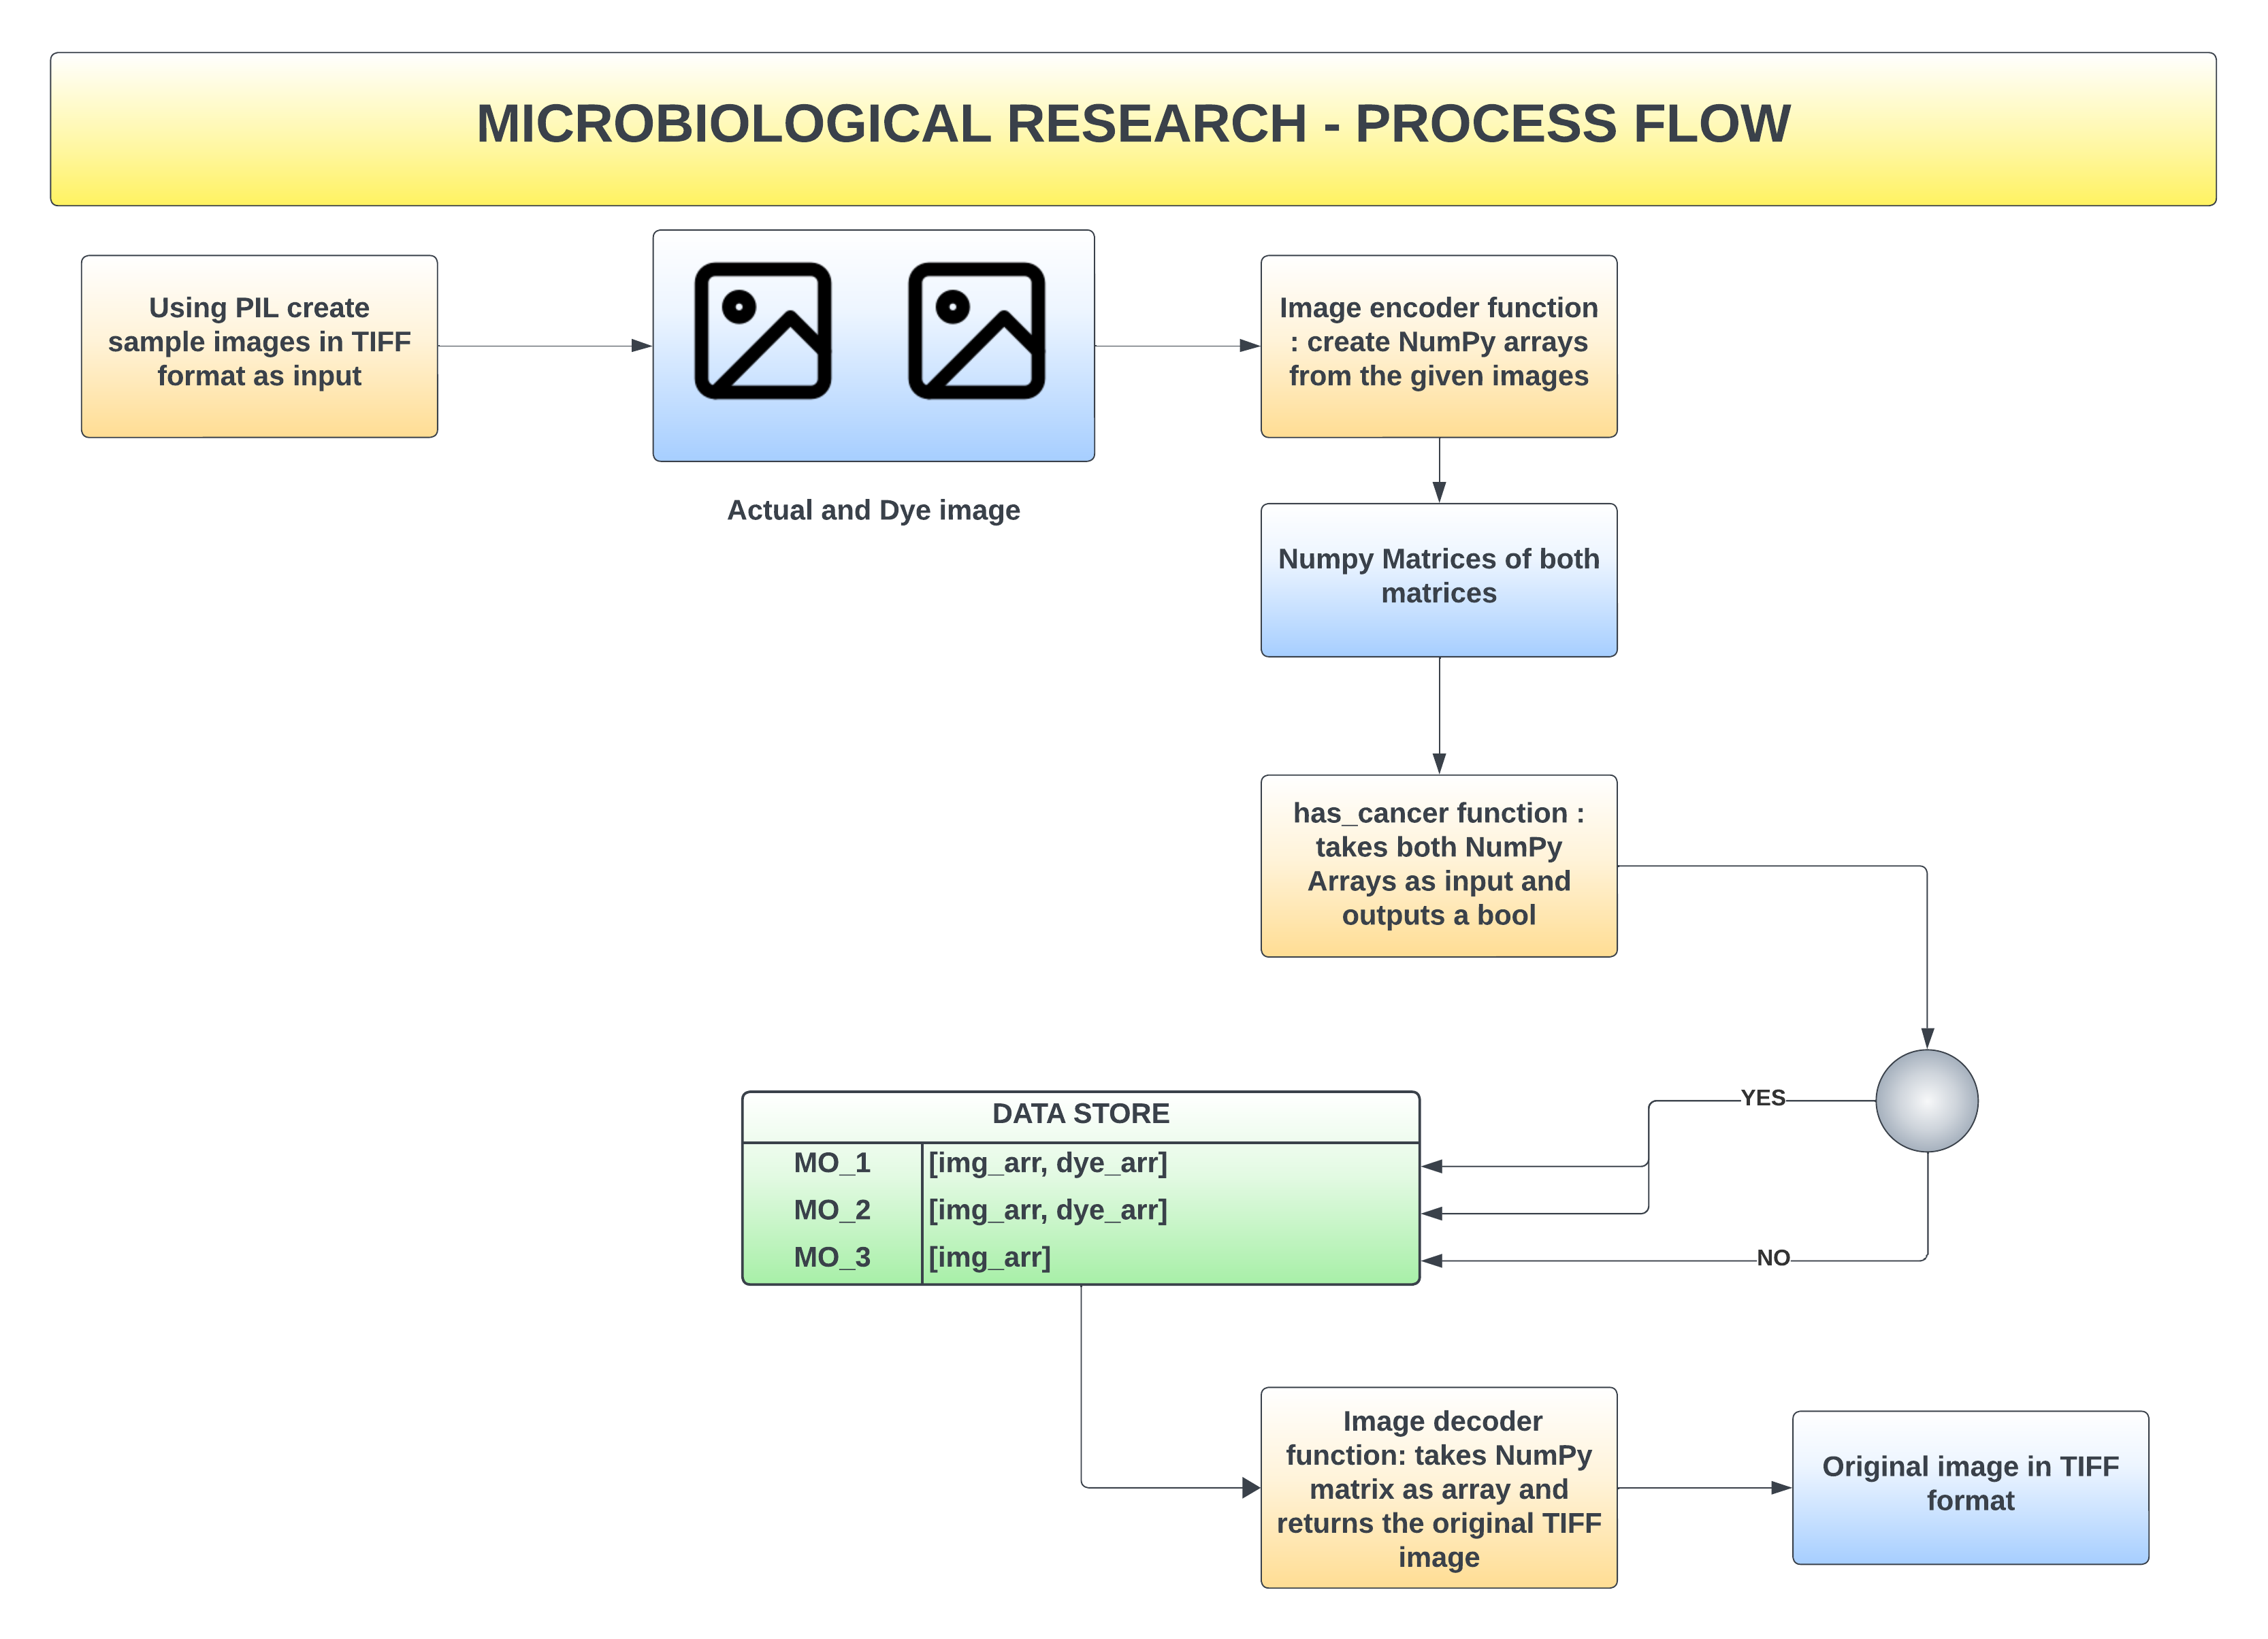

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit.png')

Note - If the image does not load, please open 'Dragonfruit.png' for the process flow diagram 

## BRIEF EXPLANATION OF PREVIOUS IMPLEMENTATION: 
- 1. Generated .Tiff compressed images to simulate the microscope and the the dye senson image
- 2. Converted the large images to dense numpy matrices for processing with an encoder function
- 3. defined an optimized_has_cancer() function that returned a bool that depicted if the MO had cancer or not
- 4. Stored the resultant matrices in the dictionary
- 5. Specified a decoder function which converts the dense matrix back into the original image on demand 


For previous implementation please visit this public gist : https://gist.github.com/ShikharSingh167/bf126a072fc9f4fb97dc69aa1b923d41

For the entire previous implementation with input and output files please visit this gdrive link : https://drive.google.com/drive/folders/11kIDx0BxYtWfuHhj816JtsDhL2yTKdSW?usp=sharing

In [2]:
! pip install Pillow -q
! pip install numpy -q
! pip install tqdm -q

In [3]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import time  
import os
Image.MAX_IMAGE_PIXELS = None

In [4]:
#######################################
####### IMAGE GENERATION CODE #########
#######################################

# # Define the image dimensions
# width = 100000
# height = 100000
# # Create an empty NumPy array of zeros with the specified dimensions
# image = np.zeros((height, width), dtype=np.uint8)
# # Set the top-left quadrant to 1
# image[:height // 2, :width // 2] = 1
# # Enable compression and save the image with compression
# compression = "tiff_lzw"  # You can choose the compression method you prefer
# with tqdm(total=3, desc="Processing images") as pbar:
#     image_pil = Image.fromarray(image)
#     image_pil.save("mo1.tiff", compression=compression)
#     pbar.update(1)
#     # Set the center pixel to 1 in the image (dye_img_pos.tiff)
#     image[height // 2, width // 2] = 1
#     image_pil = Image.fromarray(image)
#     image_pil.save("dye1.tiff", compression=compression)
#     pbar.update(1)
#     # Reset image to all zeros
#     image = np.zeros((height, width), dtype=np.uint8)
#     # Save an empty image (dye_img_neg.tiff)
#     image_pil = Image.fromarray(image)
#     image_pil.save("dye2.tiff", compression=compression)
#     pbar.update(1)


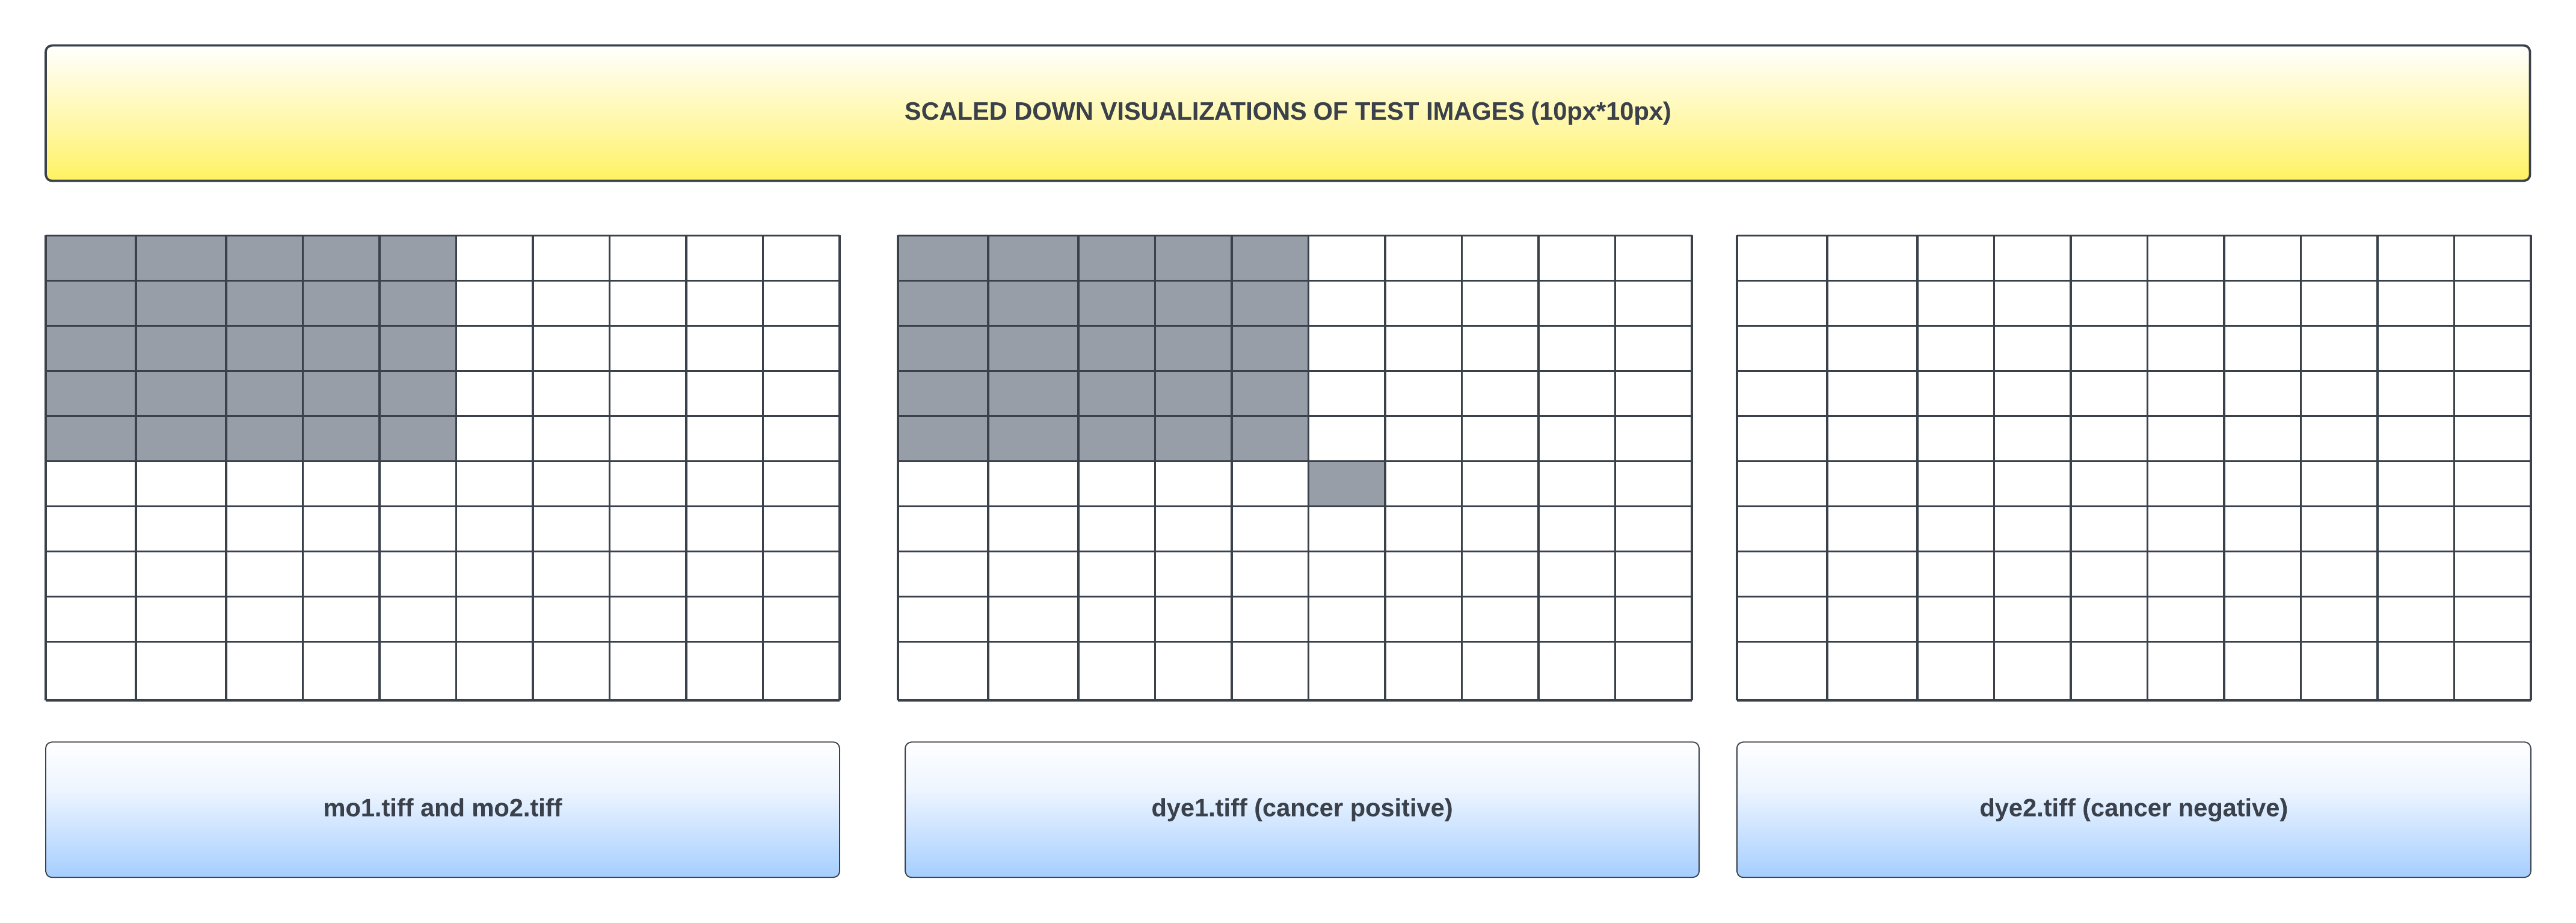

In [5]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_test_images.png')

## NEW APPROACH:

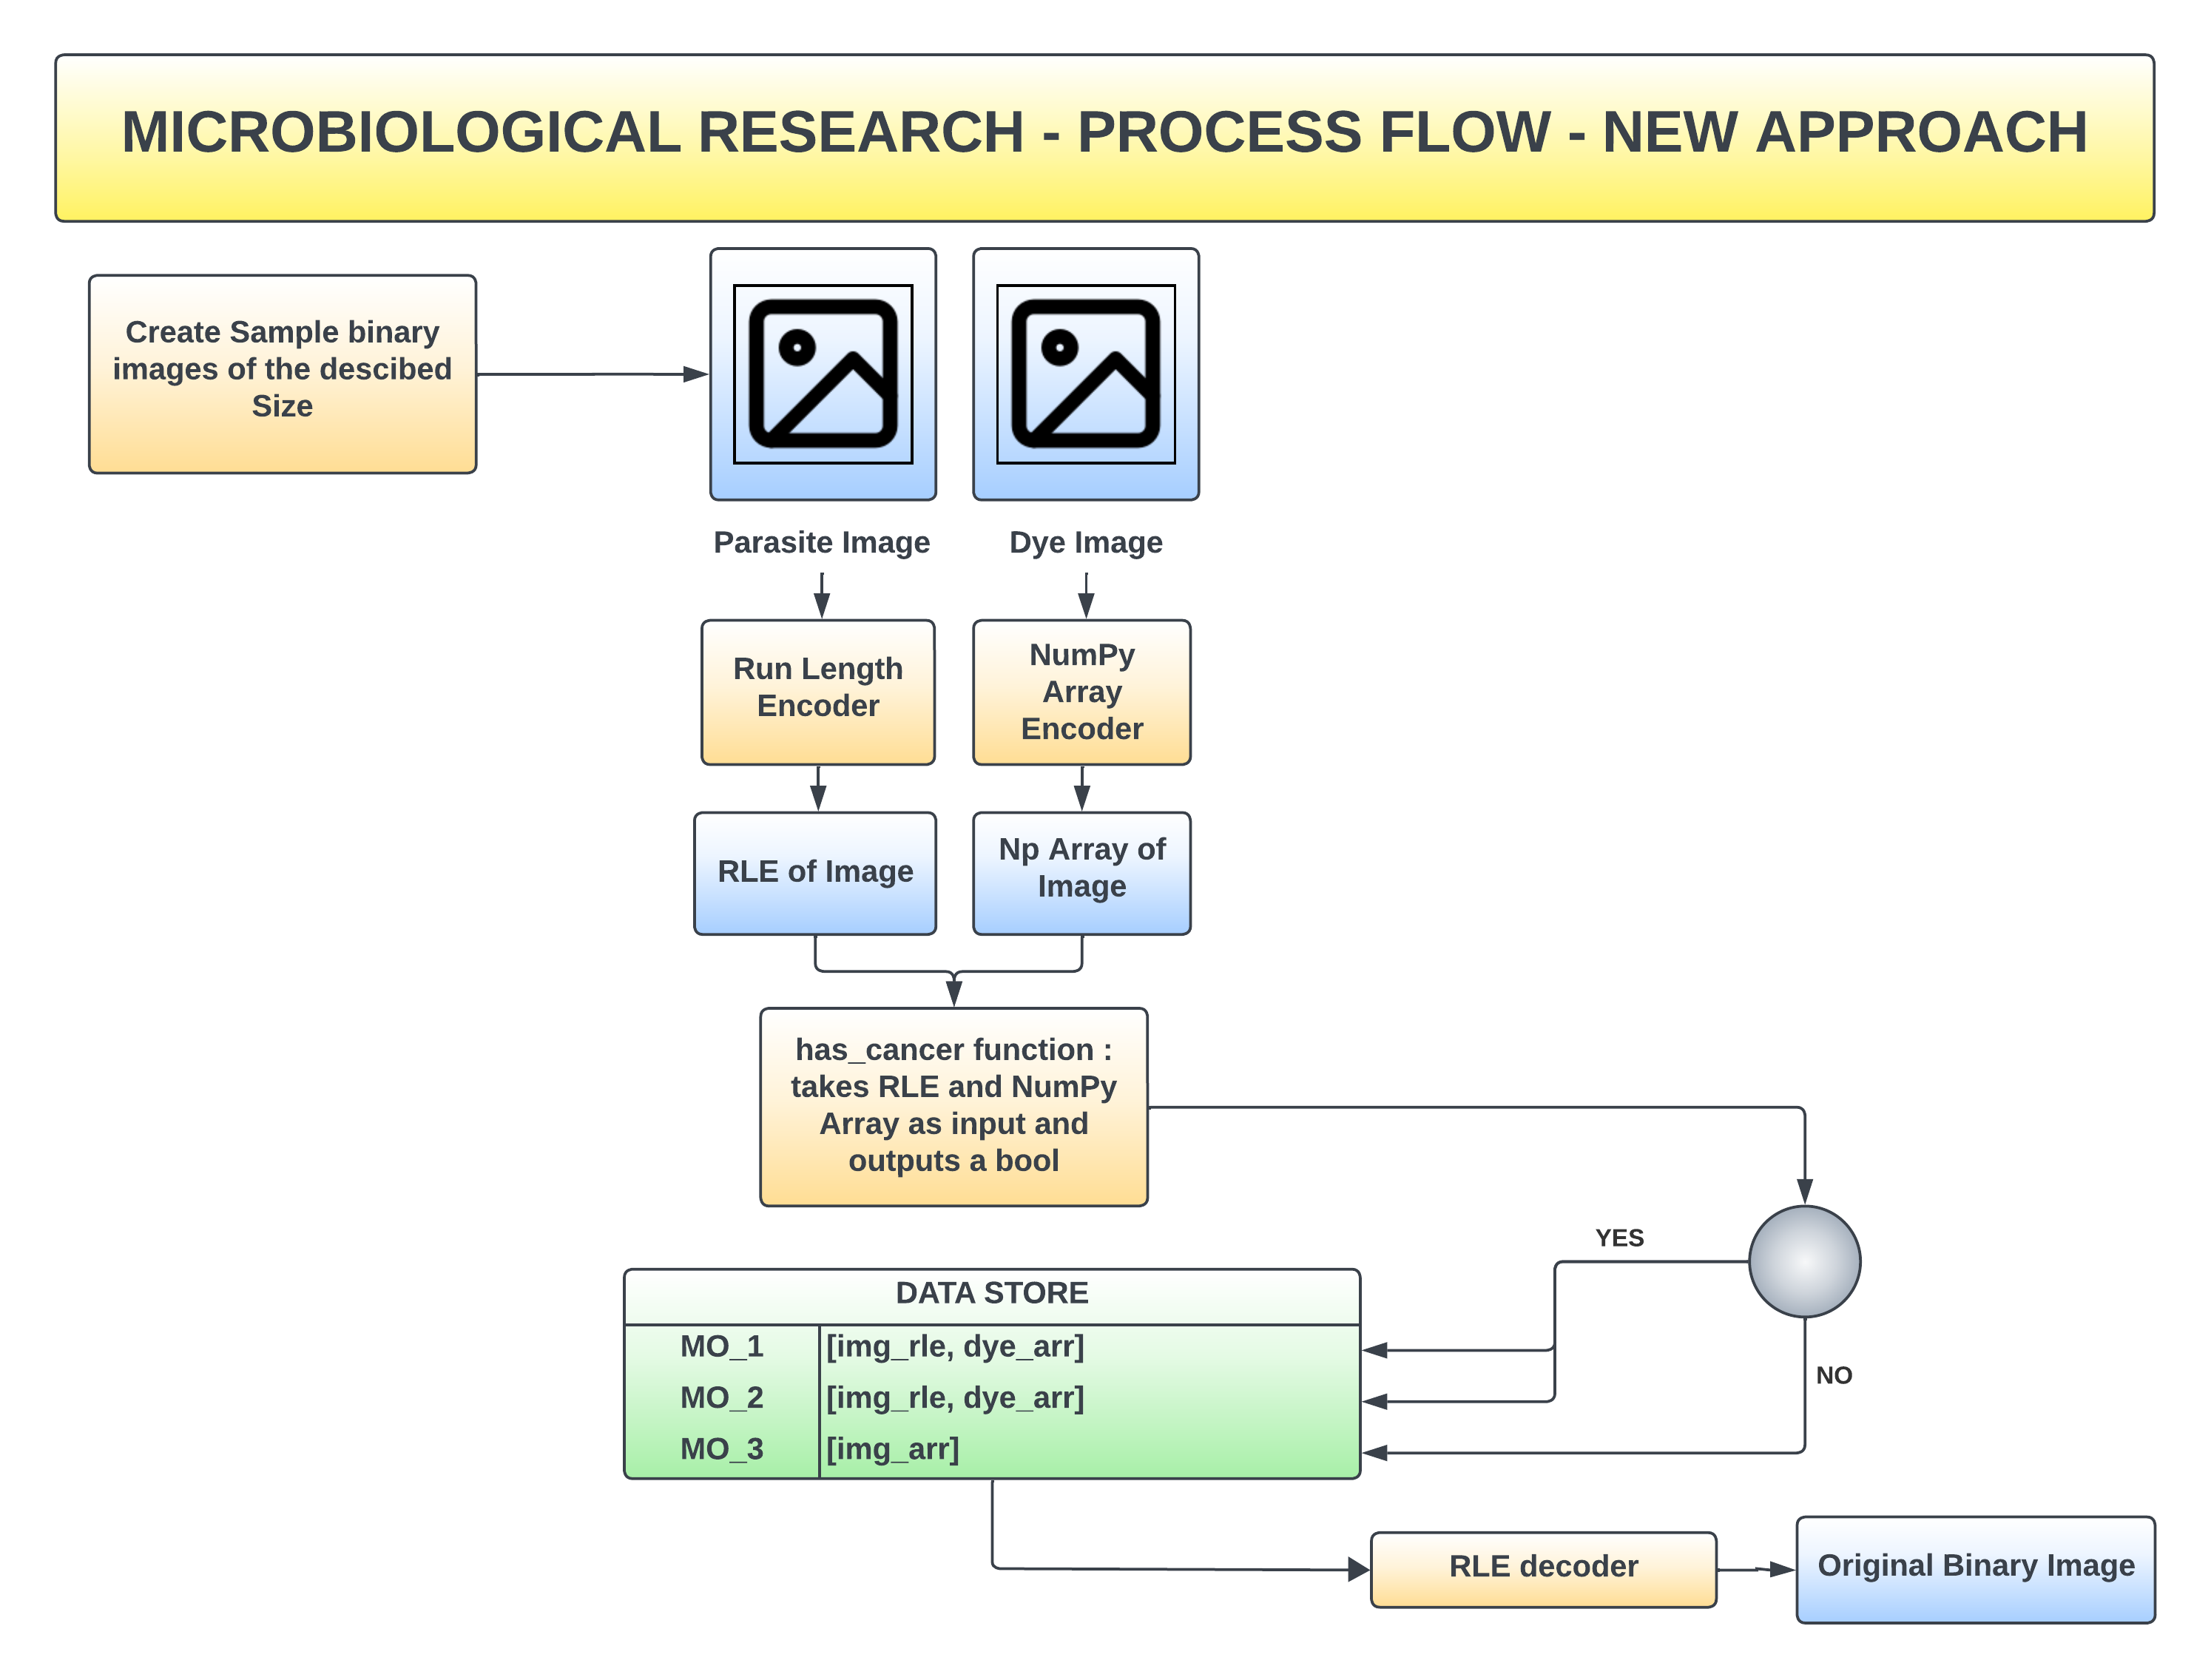

In [6]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_new_approach.png')

## NEW APPROACH : 
Let us look at these two images separately (MO image and the DYE Image)

#### MO IMAGE:
- 1. It is given that this contains a blob of black pixels which takes up 25% of the total image
- 2. These pixels are continuous in nature. i.e the black pixels are grouped together and similarly the white pixels are the complement of black pixels
- 3. Therefore there are long sequences of only 'one color' pixels. In this case, we can use Run Length Encoding the encode the binary images.
- 4. RLE basically counts the number of continuous pixels and gives a lossless compression of the MO image

#### DYE IMAGE:
- 1. It is given that this covers part or more of the MO body and may leak outside as well
- 2. In the worst case, the dye covers 100% of Image - maximum leakage, and to model this we will continue to use dense NumPy arrays
- 5. This is the best candidate for the representation of dye image

## PROCESS:

#### ENCODER - TIFF IMAGE TO DENSE NUMPY MATRIX

In [7]:
from PIL import Image
def encode_img(img):
    img = Image.open(img)
    image_array = np.array(img)
    return image_array

#### ENCODING IMAGES

In [8]:
mo1_array = encode_img('mo1.tiff')

In [9]:
dye1_array = encode_img('dye1.tiff')

In [10]:
dye2_array = np.zeros((100000, 100000), dtype=np.uint8) # since this image only has 0 values, using np.zeros() is computationally much faster

#### ENCODER - DENSE NUMPY MATRIX TO RUN LENGTH ENCODED IMAGE

In [11]:
def rle_encode(img_array):
    rows, cols = img_array.shape
    rle_data = []
    
    prev_value = img_array[0, 0]
    count = 1

    # Add tqdm around the outer loop (rows) for progress tracking
    for r in tqdm(range(rows), desc="Encoding"):
        for c in range(cols):
            if (r == 0 and c == 0):  # Skip the first pixel since we already initialized it
                continue
            
            current_value = img_array[r, c]
            
            if current_value == prev_value:
                count += 1
            else:
                rle_data.extend([prev_value, count])
                prev_value = current_value
                count = 1

    rle_data.extend([prev_value, count])  # Add the last run
    return rle_data


#### RUN LENGTH ENCODING THE PARASITE IMAGE

In [12]:
mo1_rle = rle_encode(mo1_array)

Encoding: 100%|██████████| 100000/100000 [14:50<00:00, 112.32it/s]


#### VERIFYING CORRECTNESS OF RUN LENGTH ENCODING FUNCTION

In [13]:
def rle_decode(rle_data, shape):
    """Decodes an RLE encoded array to its original form."""
    array = np.zeros(shape, dtype=np.uint8)
    position = 0
    
    for i in range(0, len(rle_data), 2):
        value = rle_data[i]
        count = rle_data[i+1]
        
        # Mark the positions with the given value
        array.flat[position:position+count] = value
        position += count
    
    return array

def verify_rle(original_array):
    rle_data = rle_encode(original_array)
    decoded_array = rle_decode(rle_data, original_array.shape)
    
    # Use numpy's array_equal function to check if two arrays are the same
    return np.array_equal(original_array, decoded_array)

def random_binary_array(shape):
    return np.random.randint(0, 2, shape)

def checkerboard_array(shape):
    array = np.indices(shape).sum(axis=0) % 2
    return array.astype(np.uint8)

def striped_array(shape):
    array = np.zeros(shape, dtype=np.uint8)
    array[:, ::2] = 1
    return array

# Random Binary Array
test_array_random = random_binary_array((100, 100))
print(verify_rle(test_array_random))  # Expected: True

# Checkerboard Pattern
test_array_checkerboard = checkerboard_array((100, 100))
print(verify_rle(test_array_checkerboard))  # Expected: True

# Striped Pattern
test_array_striped = striped_array((100, 100))
print(verify_rle(test_array_striped))  # Expected: True


Encoding: 100%|██████████| 100/100 [00:00<00:00, 76329.46it/s]


True


Encoding: 100%|██████████| 100/100 [00:00<00:00, 40287.23it/s]


True


Encoding: 100%|██████████| 100/100 [00:00<00:00, 89507.13it/s]

True


### PREVIOUS IMPLEMENTATION HAS_CANCER() FUNCTIONS:
I defined my has_cancer() function :
- Here, I compute the non-zero values of each image array
- I check if the  value : count(common non_zero values)/count(non_zero values in actual image) is over the threshold of 0.1
- If it is , then the MO has cancer




In [14]:
def has_cancer(array1, array2):
    start_time = time.time()
    # Ensure both arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Count the number of positions where both arrays have a value of 1
    common_ones = np.count_nonzero((array1 == 1) & (array2 == 1))

    # Count the number of 1 values in the first array
    total_ones_in_array1 = np.count_nonzero(array1 == 1)

    # Calculate the ratio
    ratio = common_ones / total_ones_in_array1

    # Check if the ratio is greater than 0.1
    if ratio > 0.1:
        result =  True
    else:
        result =  False
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the execution time
    print(f"Execution time: {elapsed_time} seconds")

    return result

I refined my has_cancer() implementation:
- Here, instead of computing common 1 values for each matrix, I multiply the two matrices element-wise.
- Then I simply count the number of non_zero values for the element-wise multiplication divided by number of 1's in image matrix
- This saves me computation time and significantly reduces my runtime

In [15]:
def has_cancer_optimized(array1, array2):
    start_time = time.time()
    # Ensure both arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Calculate the element-wise product of the two arrays
    elementwise_product = array1 & array2

    # Count the number of positions where both arrays have a value of 1
    common_ones = np.count_nonzero(elementwise_product)

    # Count the number of 1 values in the first array
    total_ones_in_array1 = np.count_nonzero(array1)

    # Calculate the ratio
    ratio = common_ones / total_ones_in_array1

    # Check if the ratio is greater than 0.1
    if ratio > 0.1:
        result = True
    else:
        result = False
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the execution time
    print(f"Execution time: {elapsed_time} seconds")

    return result


#### TESTING PREVIOUS IMPLEMENTATION HAS_CANCER() ON SAMPLE IMAGES


In [16]:
print(has_cancer(mo1_array,dye1_array))

Execution time: 16.145560026168823 seconds
True


In [17]:
print(has_cancer_optimized(mo1_array,dye1_array))

Execution time: 7.913641929626465 seconds
True


In [18]:
print(has_cancer_optimized(mo1_array,dye2_array))

Execution time: 8.7917640209198 seconds
False


### NEW IMPLEMENTATION HAS_CANCER() FUNCTION
- takes the RLE of the parasite image, and the dense array of the dye image as input and returns whether the parasite has cancer or not

In [19]:
def has_cancer_rle(rle_encoded_array1, array2):
    start_time = time.time()
    
    common_ones = 0
    total_ones_in_array1 = 0
    position = 0

    for i in range(0, len(rle_encoded_array1), 2):
        value = rle_encoded_array1[i]
        count = rle_encoded_array1[i+1]
        
        if value == 1:
            total_ones_in_array1 += count
            common_ones += np.count_nonzero(array2[position:position+count])
            
        position += count
    
    # Calculate the ratio
    if total_ones_in_array1 == 0:
        ratio = 0
    else:
        ratio = common_ones / total_ones_in_array1

    # Check if the ratio is greater than 0.1
    result = ratio > 0.1
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the execution time
    print(f"Execution time: {elapsed_time} seconds")

    return result


#### VERIFYING CORRECTNESS OF NEW IMPLEMENTATION HAS_CANCER() FUNCTION

In [20]:
def test_function():
    # Test 1: Basic overlap
    rle_encoded = [1, 2, 0, 3]
    array2 = [1, 1, 0, 0, 0]
    assert has_cancer_rle(rle_encoded, array2) == True, "Test 1 Failed"

    # Test 2: No overlap
    rle_encoded = [1, 2, 0, 3]
    array2 = [0, 0, 0, 0, 0]
    assert has_cancer_rle(rle_encoded, array2) == False, "Test 2 Failed"

    # Test 3: Edge case: Empty array
    rle_encoded = []
    array2 = []
    assert has_cancer_rle(rle_encoded, array2) == False, "Test 3 Failed"

    print("All tests passed!")

test_function()

Execution time: 7.772445678710938e-05 seconds
Execution time: 6.9141387939453125e-06 seconds
Execution time: 1.1920928955078125e-06 seconds
All tests passed!


#### TESTING NEW IMPLEMENTATION HAS_CANCER() FUNCTION WITH SAMPLE DATA


In [21]:
print(has_cancer_rle(mo1_rle,dye1_array))

Execution time: 1.0798819065093994 seconds
True


In [22]:
print(has_cancer_rle(mo1_rle,dye2_array))

Execution time: 1.0040698051452637 seconds
False


#### OBSERVATION : OUR NEW FUNCTION PRODUCES RESULTS MUCH FASTER THAN PREVIOUS IMPLEMENTATIONS


### STORAGE :

Let's analyze the worst-case storage size of dense array and the RLE encoding of a binary image.

In RLE encoding, the worst-case scenario for binary images is when the value alternates between 0 and 1 for every pixel because it results in the most run segments. In this case, each run segment will be of length 1, and for every pixel, you will store both its value and the run length.

Given an image of size = (N *  M):
- 1. There are (N * M) pixels in total.
- 2. In the worst case, the RLE encoding will have (2 * N * M) elements (alternating values and counts).

However, this is just the length of the RLE data. To determine the actual storage size, we need to consider the size of each element:
Assuming each value and count in the RLE encoding is stored as an integer (typically 4 bytes for int32):
- Worst-case storage size for the RLE encoding = (2 * N * M * 4 bytes)

- For the dense dye arrays, the storage size will be:
- 1. Each pixel is a uint8, which is 1 byte.
- 2. Total size = (N * M * 1 byte).

Comparing the two:
- 1. Worst-case storage for RLE = (8 * N * M) bytes = (8 * 10^10) = 80GB
- 2. Storage for the dense array = (1 * N * M) bytes = (1 * 10^10) = 10GB

In the worst-case scenario, the RLE encoding will consume 8 times more storage than the original dense array. However, it's important to note that this worst-case scenario is quite rare for natural or even most synthetic images. RLE is usually beneficial for images with large contiguous regions of the same pixel value.In our use case, worst-case scenario will most likely never occur, since the parasite is always a single continuous blob on the image


### COMBINED DATA STRUCTURE

In [23]:
image_data = {}
import os
def process_images(microscope_image, dye_image):
    # Extract the base filename without the extension
    key = os.path.splitext(os.path.basename(microscope_image))[0]

    # Convert microscope_image and dye_image to NumPy arrays
    microscope_array = encode_img(microscope_image)
    microscope_rle = rle_encode(microscope_array)
    dye_array = encode_img(dye_image)

    # Check if the images have cancer using has_cancer_optimized function
    if has_cancer_optimized(microscope_rle, dye_array):
        # If True, store both images in the dictionary
        image_data[key] = [microscope_rle, dye_array]
    else:
        # If False, store only the microscope image
        image_data[key] = [microscope_rle, None]

### RESULTANT DICTIONARY:
Each MO id will have a reference to the RLE of the parasite image, and a reference to dense matrix of the dye image


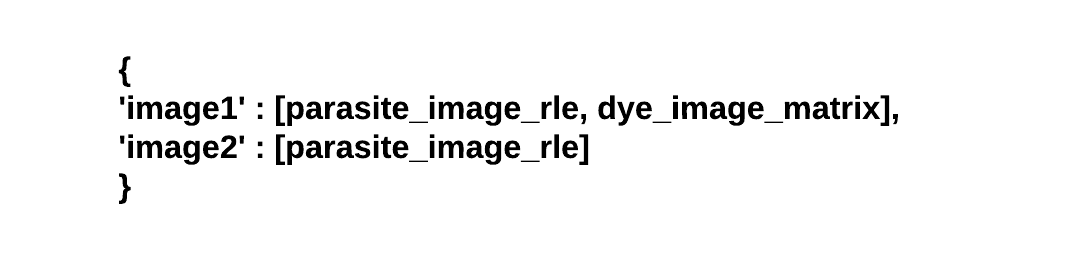

In [24]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_datastructure_format1.png')

Note - If the image does not load, please open 'Dragonfruit_datastructure_format1.png' for the datastructure format

### DECODER FUNCTION
- Finally, I specify a decoder function which takes an RLE encoding and creates a .TIFF File
- This function is to be used on demand by the researchers
- If they want to retreive a particular image they simply need to search for the key - which is the original image name and then pass the RLE through the decoder function to get a reconstructed .TIFF image

In [25]:
from PIL import Image

def save_rle_as_tiff(rle_data, shape, filename, compression="tiff_lzw"):
    # Decode the RLE data
    img_array = rle_decode(rle_data, shape)
    # Convert to PIL Image
    img_pil = Image.fromarray(img_array)
    # Save as .tiff
    img_pil.save(filename, compression=compression)

In [26]:
# EXAMPLE USAGE
# img_shape = (100000, 100000)
# save_rle_as_tiff(mo1_rle,img_shape, "output_image.tiff")

## ANSWERS TO QUESTIONS ASKED IN THE CHALLENGE:

### QUESTION 1 : 
Come up with efficient data structures to represent both types of images: those generated
by the microscope, and those generated by the dye sensor. These need not have the same
representation; the only requirement is that they be compact and take as little storage
space as possible. Explain why you picked the representation you did for each image type,
and if possible estimate how much storage would be taken by the images. What is the
worst-case storage size in bytes for each image representation you chose?

### ANSWER 1:
I have chosen Run Length Encoding for my parasite image and Dense Matrices for the dye images
- The RLE data structure is essentially a list (or array) of tuples, where each tuple consists of a pixel color and its consecutive run length. This structure can efficiently represent regions of the same color.
- The dense matrices are stored in 2D Matrix format

 - RLE FORMAT :
[
    (color_1, run_length_1),
    (color_2, run_length_2),
    ...
]

I have explained the reason behind picking these two representations and approximated the worst case storage in my implementation above

### QUESTION 2 : 
Before the researchers give you real images to work with, you would like to test out any
code you write. To this end, you would like to create “fake” simulated images and pretend
they were captured by the microscope and the dye sensor. Using the data structures you
chose in (1) above, write code to create such simulated images. Try and be as realistic in the
generated images as possible.

### ANSWER 2 :

 I have defined a decoder function, which takes an rle encoding as input and returns an image in .tiff file as the output.

- I use the Pillow python library for this task
- For my fake or simulated images, I create 3 such images:
- 1. mo1 : image with top left quadrant completely black and everything else white
- 3. dye1 : image with top left quadrant completely black and a single additional blob - adjacent pixel also black (to simulate leakage)
- 4. dye2 : image with no black values for negative test

I have then encoded mo1.tiff using RLE encoding. Similarly, I have encoded dye1.tiff and dye2.tiff into dense Numpy Matrices


### QUESTION 3 : 
Using the simulated images generated by the code you wrote for (2) above as input, write a
function to compute whether a parasite has cancer or not.

### ANSWER 3 : 

Previous has_cancer() implementations : 

I defined my has_cancer() function :
- Here, I compute the non-zero values of each image array
- I check if the  value : count(common non_zero values)/count(non_zero values in actual image) is over the threshold of 0.1
- If it is , then the MO has cancer


I refined my has_cancer() implementation:
- Here, instead of computing common 1 values for each matrix, I multiply the two matrices element-wise.
- Then I simply count the number of non_zero values for the element-wise multiplication divided by number of 1's in image matrix
- This saves me computation time and significantly reduces my runtime

### QUESTION 4 : 
You give your code from (3) to the researchers, who run it and find that it is running too
slowly for their liking. What can you do to improve the execution speed? Write the code to
implement the fastest possible version you can think of for the function in (3).

### ANSWER 4 : 

I specified a new has_cancer_rle() function. This has the below key-points :

- Efficiency with RLE: The function processes rle_encoded_array1 in a run-length encoded format. Instead of decoding it fully, it directly uses the RLE values to compute the desired metrics, making it memory-efficient.

- Parallel Counting: For each run of "1"s found in rle_encoded_array1, the function calculates both the count of ones in that run and the count of corresponding ones in the same positions of array2. This is done efficiently using slicing and numpy's count_nonzero.

- Ratio-based Decision: The function determines the "cancer" status by calculating the ratio of common_ones to total_ones_in_array1. If this ratio exceeds 0.1 (or 10%), the function returns True, indicating the presence of "cancer". Otherwise, it returns False




### OBSERVATION : This optimized function runs much faster than our original functions

## ENHANCEMENTS and CONSIDERATIONS:

- We can scale our images down (Down-sampling) to a more consumable format. For example a 100000 * 100000 pixel image can be downsampled to a 10 * 10 pixel image, keeping the same information.
- For this we can just divide the original image into tiles and create a resultant image where each pixel represents a tile. However, the challenge would be that if the image is not uniform, then we'd have to use thresholding to assign 1 or 0 to the tile, which becomes an accuracy consideration

- Also we can think of superimposition of the dye and the microscope image right after they are captured. This will result in a single matrix with  dye pixels, mo+dye pixels, mo pixels and blank pixels. Now we can calculate if count(mo+dye)/count(mo) > 0.1 . Therefore we need to work with only one matrix. And finally we extract the original image from the combined image and store it in our datastructure according to the rule

## TOOLS USED
- Google - to research about large images
- ChatGPT - for code assistance and debugging
- Lucid chart  - for visualizations
- Python - Specially tifffile and PIL packages, for helping me work with images

## FINAL THOUGHTS AND COMMENTS

I thank the DragonFruit AI team for taking the time to review my original submission. I have tried my best to incoporate the feedback received on my original submission in this new submission. I tried a few different methods and faced hiccups regarding memory and computational power along the way, and this was the best experiment I could simulate given my resources. I am excited for the DragonFruit AI team to review my updated solution and provide me feedback for the same

Looking forward to hearing from you!

Yours Sincerely,
Shikhar Singh